In [378]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut
import matplotlib.pyplot as plt

In [209]:
D = pd.read_hdf('//FS2.smpp.local\RTO\CIS-PD MUSC\decoded_forms\\form509.h5')

In [210]:
sum(D.Q03=='Left')/len(D)

0.6700507614213198

## Tremor Scores

In [292]:
taskList = np.array(['Standing', 'Walking', 'Walking while counting', 'Finger to nose--right hand', 
                     'Finger to nose--left hand', 'Alternating right hand movements', 
                     'Alternating left hand movements', 'Sit to stand', 'Drawing on a paper', 
                     'Typing on a computer keyboard', 'Assembling nuts and bolts', 
                     'Taking a glass of water and drinking', 'Organizing sheets in a folder', 'Folding towels', 
                     'Sitting'])
taskList_Abb = np.array(['Stndg', 'Wlkg', 'WlkgCnt', 'FtnR', 'FtnL', 'RamR', 'RamL', 'SitStand', 
                         'Drwg', 'Typg', 'NtsBts', 'Drnkg', 'Sheets', 'Fldg', 'Sitng'])

In [293]:
Questions = pd.read_sas('//FS2.smpp.local\RTO\CIS-PD MUSC\datadictionary.sas7bdat')
Questions = Questions[Questions.zFormID == 509.0]
Questions = Questions.drop(columns = list(set(Questions.columns)-set(['zFieldNm','zFieldNb'])))
Questions.zFieldNm = Questions.zFieldNm.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)
Questions.zFieldNb = Questions.zFieldNb.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)
## Correct Typos
Questions.loc[Questions.zFieldNm=='Walking  tremor left upper limb rating','zFieldNm'] = 'Walking tremor left upper limb rating'
Questions.loc[Questions.zFieldNb=='Q70','zFieldNm'] = 'Alternating left hand movements tremor right upper limb rating'
Questions.loc[Questions.zFieldNb=='Q145','zFieldNm'] = 'Sitting tremor right upper limb rating'

In [294]:
AllScores = pd.DataFrame()
for ind in D.index:
    row = D.loc[ind,:]
    side = row.Q03
    if side == 'left':
        SideDict = {'FtnR': 'FtnC', 'FtnL': 'FtnI', 'RamR':'RamC', 'RamL':'RamI'}
    else:
        SideDict = {'FtnR': 'FtnI', 'FtnL': 'FtnC', 'RamR':'RamI', 'RamL':'RamC'}
        
    try:
        side = side.lower()
    except(AttributeError):
        print(row.SubjectCode, row.VisitNm, row.Q03)
        continue
    RowScores = pd.DataFrame(columns=taskList_Abb, index=[ind])
    for task, task_abr in zip(taskList,taskList_Abb):
        QInd = Questions.zFieldNm==task+' tremor '+side+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
#         print(task+' tremor '+side+' upper limb rating',row[QNum].values)
        if task_abr in SideDict.keys():
            task_abr=SideDict[task_abr]
        RowScores[task_abr] = row[QNum].values[0]
    RowScores.index = [(row.SubjectCode,row.VisitNm)]
    AllScores = pd.concat((AllScores,RowScores))
    

1005.0 2 Weeks: Time 120 nan
1005.0 1 Month nan
1020.0 2 Weeks: Time 0 nan
1020.0 2 Weeks: Time 30 nan
1020.0 2 Weeks: Time 60 nan
1020.0 2 Weeks: Time 90 nan
1020.0 2 Weeks: Time 120 nan
1020.0 2 Weeks: Time 150 nan
1047.0 1 Month nan
1048.0 2 Weeks: Time 150 nan


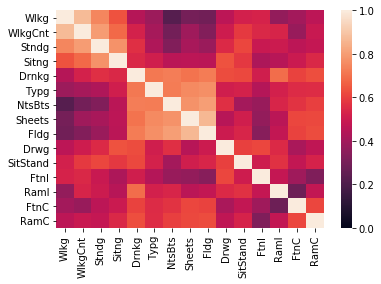

In [295]:
sns.heatmap(AllScores.corr().loc[['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC'],
                                 ['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC']]
           ,vmin=0, vmax=1)

In [296]:
AllScoresRMSE = pd.DataFrame(columns=AllScores.columns, index =AllScores.columns)
for x,y in itertools.product(AllScores.columns,AllScores.columns):
    AllScoresRMSE.loc[x,y] = ((AllScores[x]-AllScores[y])**2).mean()**.5

In [297]:
AllScoresRMSE = AllScoresRMSE[AllScoresRMSE.columns].astype(float)

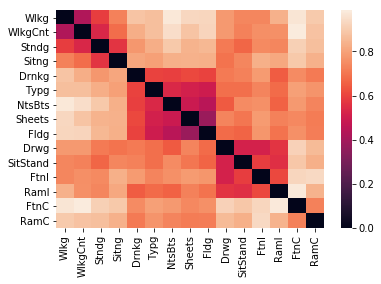

In [298]:
sns.heatmap(AllScoresRMSE.loc[['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC'],
                              ['Wlkg','WlkgCnt','Stndg','Sitng','Drnkg','Typg','NtsBts','Sheets','Fldg','Drwg','SitStand','FtnI','RamI','FtnC','RamC']]
           ,vmin=0)

In [299]:
Tremor = AllScores
Tremor.drop(columns=['RamR','RamL','FtnR','FtnL'], inplace=True)
Tremor.columns = [c+'_T' for c in Tremor.columns]

## Bradykinesia Scores

In [300]:
taskList = np.array(['Walking', 'Walking while counting', 'Finger to nose--right hand', 
                     'Finger to nose--left hand', 'Alternating right hand movements', 
                     'Alternating left hand movements', 'Drawing on a paper', 
                     'Typing on a computer keyboard', 'Assembling nuts and bolts', 
                     'Taking a glass of water and drinking', 'Organizing sheets in a folder', 'Folding towels'])
taskList_Abb = np.array(['Wlkg', 'WlkgCnt', 'FtnR', 'FtnL', 'RamR', 'RamL', 
                         'Drwg', 'Typg', 'NtsBts', 'Drnkg', 'Sheets', 'Fldg'])

In [301]:
Questions = pd.read_sas('//FS2.smpp.local\RTO\CIS-PD MUSC\datadictionary.sas7bdat')
Questions = Questions[Questions.zFormID == 509.0]
Questions = Questions.drop(columns = list(set(Questions.columns)-set(['zFieldNm','zFieldNb'])))
Questions.zFieldNm = Questions.zFieldNm.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)
Questions.zFieldNb = Questions.zFieldNb.apply(
    lambda x: x.replace(b'\x92',b"'").replace(b'\x97',b'--').decode() if isinstance(x, bytes) else x)

In [302]:
AllScores = pd.DataFrame()
for ind in D.index:
    row = D.loc[ind,:]
    side = row.Q03
    if side == 'Left':
        SideDict = {'FtnR': 'FtnC', 'FtnL': 'FtnI', 'RamR':'RamC', 'RamL':'RamI'}
    else:
        SideDict = {'FtnR': 'FtnI', 'FtnL': 'FtnC', 'RamR':'RamI', 'RamL':'RamC'}
        
    try:
        side = side.lower()
    except(AttributeError):
        print(row.SubjectCode, row.VisitNm, row.Q03)
        continue
    RowScores = pd.DataFrame(columns=taskList_Abb, index=[ind])
    for task, task_abr in zip(taskList,taskList_Abb):
        if (task_abr[-1].lower()!=side[0])&((task_abr[-1]=='R')|(task_abr[-1]=='L')):
            continue
        QInd = Questions.zFieldNm==task+' bradykinesia '+side+' upper limb'
        if sum(QInd)<1:
            QInd = Questions.zFieldNm==task+' bradykinesia '+side+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
#         print(task+' tremor '+side+' upper limb rating',row[QNum].values)
        if task_abr in SideDict.keys():
            task_abr=SideDict[task_abr]
        RowScores[task_abr] = row[QNum].values[0]
    RowScores.index = [(row.SubjectCode,row.VisitNm)]
    AllScores = pd.concat((AllScores,RowScores))
    

1005.0 2 Weeks: Time 120 nan
1005.0 1 Month nan
1020.0 2 Weeks: Time 0 nan
1020.0 2 Weeks: Time 30 nan
1020.0 2 Weeks: Time 60 nan
1020.0 2 Weeks: Time 90 nan
1020.0 2 Weeks: Time 120 nan
1020.0 2 Weeks: Time 150 nan
1047.0 1 Month nan
1048.0 2 Weeks: Time 150 nan


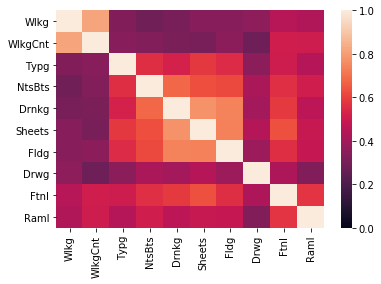

In [303]:
sns.heatmap(AllScores.corr().loc[['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI'],
                                 ['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI']],vmin=0, vmax=1)

In [304]:
AllScoresRMSE = pd.DataFrame(columns=AllScores.columns, index =AllScores.columns)
for x,y in itertools.product(AllScores.columns,AllScores.columns):
    AllScoresRMSE.loc[x,y] = ((AllScores[x]-AllScores[y])**2).mean()**.5

In [305]:
AllScoresRMSE = AllScoresRMSE[AllScoresRMSE.columns].astype(float)

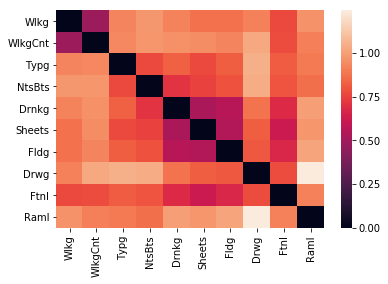

In [306]:
sns.heatmap(AllScoresRMSE.loc[['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI'],
                              ['Wlkg','WlkgCnt','Typg','NtsBts','Drnkg','Sheets','Fldg','Drwg','FtnI','RamI']],vmin=0)

In [307]:
Brady = AllScores
Brady.drop(columns=['RamR','RamL','FtnR','FtnL'], inplace=True)
Brady.columns = [c+'_B' for c in Brady.columns]

## Corrleate with MDS-UPDRS

In [308]:
AllScores = pd.concat((Tremor,Brady),axis=1)

#### Extract MDS-UPDRS Scores

In [231]:
form508 = pd.read_hdf('//FS2.smpp.local\\RTO\\CIS-PD MUSC\\decoded_forms\\form508.h5')

In [390]:
form508.head(2)

,SubjectCode,SiteID,VisitNm,FormDate,Q33,Q34,Q35,Q36,Q37,Q38,...,Q64,Q65,Q02,Q01,Q66,Q67,Q68,DataCollected,Qb2_UTC,FormTime
0,1003.0,1313.0,2 Weeks: Time 0,2017-07-03,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,1.0,NaN,Off,No,NaN,Severe disability; still able to walk or stand...,Yes,2017-07-03 15:20:44,10:20:44
1,1003.0,1313.0,2 Weeks: Time 60,2017-07-03,1.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,NaN,On,No,NaN,Bilateral involvement without impairment of ba...,Yes,2017-07-03 17:11:39,12:11:39


In [386]:
UPDRS = form508[['SubjectCode', 'VisitNm', 'Q01', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45',
         'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 'Q55',
         'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65']].copy()
UPDRS.index = [(row[1].SubjectCode,row[1].VisitNm) for row in UPDRS.iterrows()]

In [387]:
UPDRS['UPDRS Part III'] = UPDRS[['Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45',
         'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 'Q55',
         'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65']].apply(sum,axis=1)
UPDRS['UPDRS Rigidity'] = UPDRS[['Q35', 'Q36', 'Q37', 'Q38', 'Q39']].apply(sum,axis=1)
UPDRS['UPDRS Upper'] = UPDRS[['Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45']].apply(sum,axis=1)
UPDRS['UPDRS Lower'] = UPDRS[['Q46', 'Q47', 'Q48', 'Q49']].apply(sum,axis=1)
UPDRS['UPDRS Posture/Gait'] = UPDRS[['Q50', 'Q51', 'Q52', 'Q53', 'Q54']].apply(sum,axis=1)
UPDRS['UPDRS Bradykinesia'] = UPDRS[['Q55']].apply(sum,axis=1)
UPDRS['UPDRS Tremor'] = UPDRS[['Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65']].apply(sum,axis=1)

In [388]:
UPDRS

,SubjectCode,VisitNm,Q01,Q33,Q34,Q35,Q36,Q37,Q38,Q39,...,Q63,Q64,Q65,UPDRS Part III,UPDRS Rigidity,UPDRS Upper,UPDRS Lower,UPDRS Posture/Gait,UPDRS Bradykinesia,UPDRS Tremor
"(1003.0, 2 Weeks: Time 0)",1003.0,2 Weeks: Time 0,Off,2.0,2.0,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,1.0,59.0,9.0,13.0,11.0,11.0,3.0,8.0
"(1003.0, 2 Weeks: Time 60)",1003.0,2 Weeks: Time 60,On,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,40.0,9.0,12.0,6.0,3.0,2.0,5.0
"(1004.0, 2 Weeks: Time 0)",1004.0,2 Weeks: Time 0,Off,1.0,1.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,31.0,5.0,9.0,8.0,1.0,2.0,4.0
"(1004.0, 2 Weeks: Time 60)",1004.0,2 Weeks: Time 60,On,NaN,NaN,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,NaN,3.0,4.0,4.0,0.0,1.0,0.0
"(1005.0, 2 Weeks: Time 0)",1005.0,2 Weeks: Time 0,Off,1.0,1.0,1.0,1.0,2.0,1.0,2.0,...,0.0,0.0,1.0,33.0,7.0,8.0,8.0,2.0,2.0,4.0
"(1005.0, 2 Weeks: Time 60)",1005.0,2 Weeks: Time 60,On,1.0,1.0,2.0,0.0,3.0,0.0,2.0,...,0.0,0.0,1.0,32.0,7.0,8.0,5.0,2.0,1.0,7.0
"(1007.0, 2 Weeks: Time 0)",1007.0,2 Weeks: Time 0,Off,0.0,0.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,2.0,33.0,5.0,10.0,7.0,2.0,2.0,7.0
"(1007.0, 2 Weeks: Time 60)",1007.0,2 Weeks: Time 60,On,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,16.0,0.0,7.0,4.0,1.0,1.0,2.0
"(1009.0, 2 Weeks: Time 0)",1009.0,2 Weeks: Time 0,Off,1.0,2.0,3.0,3.0,2.0,3.0,2.0,...,0.0,0.0,4.0,55.0,13.0,12.0,6.0,3.0,2.0,16.0
"(1009.0, 2 Weeks: Time 60)",1009.0,2 Weeks: Time 60,On,1.0,1.0,2.0,2.0,2.0,1.0,0.0,...,0.0,0.0,1.0,26.0,7.0,5.0,4.0,2.0,2.0,4.0


In [317]:
UPDRS=UPDRS[['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
             'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor']]

#### Combine UPDRS and Motor Assessment Scores

In [381]:
CombScores.head()

Stndg_T  Wlkg_T  WlkgCnt_T  SitStand_T  Drwg_T  \
1003.0 2 Weeks: Time 0       1.0     0.0        0.0         0.0     1.0   
       2 Weeks: Time 60      0.0     0.0        0.0         1.0     0.0   
1004.0 2 Weeks: Time 0       0.0     0.0        0.0         0.0     0.0   
1005.0 2 Weeks: Time 0       0.0     0.0        0.0         1.0     1.0   
       2 Weeks: Time 60      0.0     0.0        0.0         1.0     1.0   

                         Typg_T  NtsBts_T  Drnkg_T  Sheets_T  Fldg_T  \
1003.0 2 Weeks: Time 0      0.0       1.0      1.0       2.0     1.0   
       2 Weeks: Time 60     0.0       0.0      1.0       0.0     0.0   
1004.0 2 Weeks: Time 0      1.0       1.0      0.0       1.0     1.0   
1005.0 2 Weeks: Time 0      1.0       1.0      1.0       1.0     1.0   
       2 Weeks: Time 60     1.0       1.0      1.0       1.0     1.0   

                             ...       Fldg_B  FtnI_B  RamI_B  UPDRS Part III  \
1003.0 2 Weeks: Time 0       ...          1.0     1.0     2.0            59.0   
       2 Weeks: Time 60      ...          0.0     0.0     2.0            40.0   
1004.0 2 Weeks: Time 0       ...          1.0     1.0     1.0            31.0   
1005.0 2 Weeks: Time 0       ...          2.0     2.0     3.0            33.0   
       2 Weeks: Time 60      ...          1.0     1.0     3.0            32.0   

                         UPDRS Rigidity  UPDRS Upper  UPDRS Lower  \
1003.0 2 Weeks: Time 0              9.0         13.0         11.0   
       2 Weeks: Time 60             9.0         12.0          6.0   
1004.0 2 Weeks: Time 0              5.0          9.0          8.0   
1005.0 2 Weeks: Time 0              7.0          8.0          8.0   
       2 Weeks: Time 60             7.0          8.0          5.0   

                         UPDRS Posture/Gait  UPDRS Bradykinesia  UPDRS Tremor  
1003.0 2 Weeks: Time 0                 11.0                 3.0           8.0  
       2 Weeks: Time 60                 3.0                 2.0           5.0  
1004.0 2 Weeks: Time 0                  1.0                 2.0           4.0  
1005.0 2 Weeks: Time 0                  2.0                 2.0           4.0  
       2 Weeks: Time 60                 2.0                 1.0           7.0  

[5 rows x 32 columns]

In [320]:
CombScores = pd.concat((AllScores,UPDRS),axis=1)

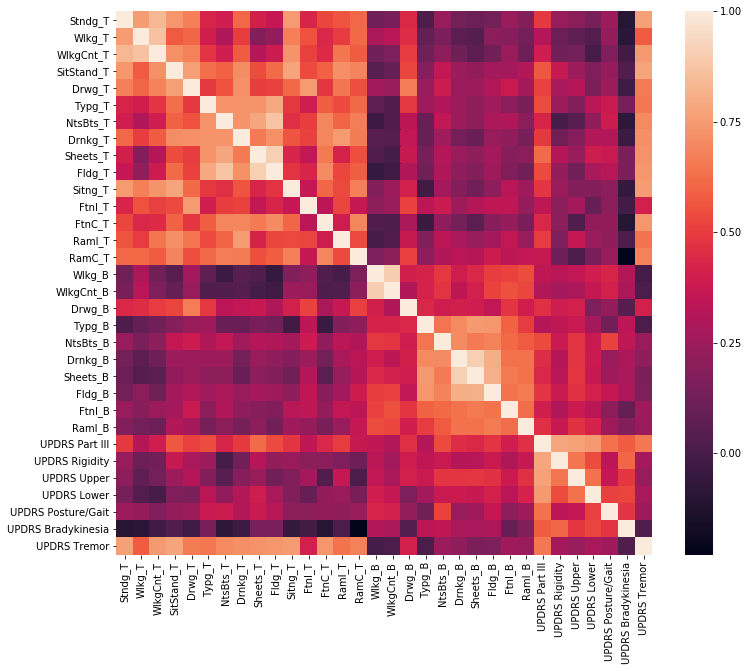

In [382]:
plt.figure(figsize=(12,10))
sns.heatmap(CombScores.corr())

### Random Forest for UPDRS Prediction

In [366]:
cf = RandomForestRegressor(n_estimators=50)
grouper = LeaveOneGroupOut()
CombScores.dropna(inplace=True)

In [367]:
CombScores.index.levels[0]

Float64Index([1003.0, 1004.0, 1005.0, 1007.0, 1009.0, 1016.0, 1018.0, 1019.0,
              1020.0, 1023.0, 1024.0, 1029.0, 1030.0, 1032.0, 1038.0, 1039.0,
              1043.0, 1044.0, 1046.0, 1047.0, 1048.0, 1049.0, 1050.0, 1051.0,
              1052.0, 1053.0, 1054.0, 1055.0, 1056.0],
             dtype='float64')

In [416]:
Outcomes = pd.DataFrame(index=CombScores.index,columns = ['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                                          'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor'])
FeatImp = np.array([])
for subj in CombScores.index.levels[0]:
    if len(CombScores.loc[subj])<1:
        continue
    for Target in Outcomes.columns:
        Train = CombScores.drop(index=subj)
        Test = CombScores.loc[subj]

        TrainFeat = Train.drop(columns=['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                        'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor']).values
        TrainScores = Train[Target].values

        TestFeat = Test.drop(columns=['UPDRS Part III', 'UPDRS Rigidity', 'UPDRS Upper', 'UPDRS Lower', 
                                      'UPDRS Posture/Gait', 'UPDRS Bradykinesia', 'UPDRS Tremor']).values
        TestScores = Test[Target]
        
        cf.fit(TrainFeat,TrainScores)
        if Target=='UPDRS Part III':
            if len(FeatImp)>1:
                FeatImp=np.vstack((FeatImp,cf.feature_importances_))
            else:
                FeatImp = cf.feature_importances_
        pred = cf.predict(TestFeat)
        for ind in range(TestScores.shape[0]):
            Outcomes.loc[(subj, TestScores.index[ind]),Target] = (pred[ind],TestScores.iloc[ind])
    
    

In [419]:
Test

,Stndg_T,Wlkg_T,WlkgCnt_T,SitStand_T,Drwg_T,Typg_T,NtsBts_T,Drnkg_T,Sheets_T,Fldg_T,...,Fldg_B,FtnI_B,RamI_B,UPDRS Part III,UPDRS Rigidity,UPDRS Upper,UPDRS Lower,UPDRS Posture/Gait,UPDRS Bradykinesia,UPDRS Tremor
2 Weeks: Time 0,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,2.0,2.0,46.0,8.0,10.0,5.0,4.0,2.0,12.0
2 Weeks: Time 60,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2.0,2.0,3.0,61.0,10.0,9.0,6.0,9.0,2.0,20.0


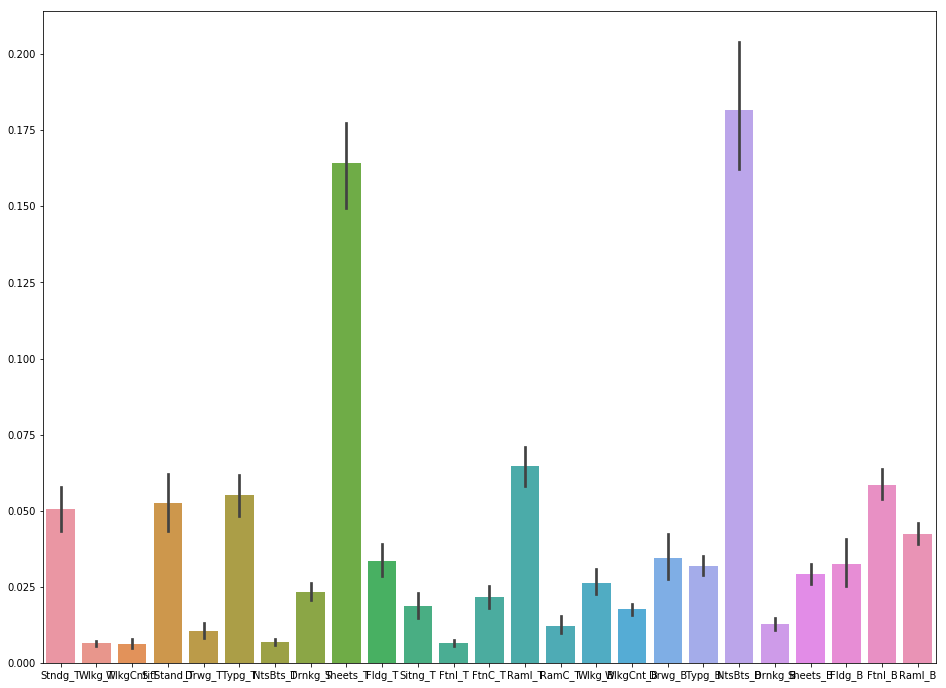

In [417]:
plt.figure(figsize=(16,12))
sns.barplot(data = pd.DataFrame(FeatImp,columns = AllScores.columns))

In [403]:
FeatImp

array([[0.10723758, 0.01091898, 0.00973668, 0.04544398, 0.00699104,
        0.10741402, 0.00775698, 0.03654437, 0.08571224, 0.03493133,
        0.02684602, 0.00950045, 0.03237796, 0.04675503, 0.00988089,
        0.01814911, 0.00822447, 0.04451633, 0.03658572, 0.07366026,
        0.02026392, 0.06993999, 0.04983408, 0.0736341 , 0.02714448],
       [0.04273441, 0.00388323, 0.00724819, 0.05883434, 0.01200306,
        0.03164701, 0.00614527, 0.02676969, 0.21126576, 0.01381714,
        0.01478107, 0.00517235, 0.0245511 , 0.04902043, 0.03940761,
        0.02681072, 0.01297777, 0.03643274, 0.03093215, 0.14263336,
        0.02323175, 0.03806153, 0.01465669, 0.07069989, 0.05628276],
       [0.04593792, 0.0069863 , 0.00793061, 0.05563694, 0.00140176,
        0.03050865, 0.00539378, 0.02848206, 0.18654791, 0.03540187,
        0.01000794, 0.0063432 , 0.0207437 , 0.08884174, 0.01977067,
        0.03105173, 0.01609806, 0.06471544, 0.0204937 , 0.1234928 ,
        0.01530045, 0.02124158, 0.03223547, 0.

In [369]:
Outcomes

UPDRS Part III  \
1003.0 2 Weeks: Time 0                (25.72, 59.0)   
       2 Weeks: Time 60  (21.362142857142857, 40.0)   
1004.0 2 Weeks: Time 0                (24.02, 31.0)   
1005.0 2 Weeks: Time 0                (34.44, 33.0)   
       2 Weeks: Time 60               (31.54, 32.0)   
1007.0 2 Weeks: Time 0                (21.56, 33.0)   
       2 Weeks: Time 60               (11.05, 16.0)   
1009.0 2 Weeks: Time 0                (30.34, 55.0)   
       2 Weeks: Time 60               (19.34, 26.0)   
1016.0 2 Weeks: Time 0                (25.28, 19.0)   
       2 Weeks: Time 60               (26.34, 21.0)   
1018.0 2 Weeks: Time 0                (27.66, 18.0)   
       2 Weeks: Time 60                (28.1, 13.0)   
1019.0 2 Weeks: Time 0               (18.548, 36.0)   
       2 Weeks: Time 60                (17.9, 14.0)   
1023.0 2 Weeks: Time 0                (34.56, 36.0)   
       2 Weeks: Time 60              (16.985, 21.0)   
1024.0 2 Weeks: Time 60               (23.58, 18.0)   
1029.0 2 Weeks: Time 0                (29.38, 42.0)   
       2 Weeks: Time 60               (23.14, 32.0)   
1030.0 2 Weeks: Time 0                 (15.2, 18.0)   
1032.0 2 Weeks: Time 0                (31.12, 28.0)   
       2 Weeks: Time 60               (25.86, 12.0)   
1038.0 2 Weeks: Time 0                (34.62, 30.0)   
       2 Weeks: Time 60              (34.687, 25.0)   
1039.0 2 Weeks: Time 0                (26.52, 29.0)   
       2 Weeks: Time 60              (19.334, 12.0)   
1043.0 2 Weeks: Time 0                 (39.1, 40.0)   
       2 Weeks: Time 60              (20.515, 16.0)   
1044.0 2 Weeks: Time 0                (20.16, 29.0)   
       2 Weeks: Time 60               (12.56, 24.0)   
1046.0 2 Weeks: Time 0                (25.84, 21.0)   
       2 Weeks: Time 60                (27.3, 18.0)   
1047.0 2 Weeks: Time 0               (24.035, 18.0)   
       2 Weeks: Time 60   (18.368142857142857, 9.0)   
1048.0 2 Weeks: Time 0                (29.92, 16.0)   
1049.0 2 Weeks: Time 60                (33.0, 24.0)   
1050.0 2 Weeks: Time 0                 (33.6, 40.0)   
       2 Weeks: Time 60               (24.86, 24.0)   
1051.0 2 Weeks: Time 0                (17.64, 14.0)   
       2 Weeks: Time 60   (16.746000000000002, 6.0)   
1052.0 2 Weeks: Time 0                (25.24, 31.0)   
       2 Weeks: Time 60               (15.92, 15.0)   
1053.0 2 Weeks: Time 0                 (17.0, 25.0)   
       2 Weeks: Time 60               (16.29, 15.0)   
1054.0 2 Weeks: Time 0                (34.42, 44.0)   
       2 Weeks: Time 60              (18.795, 15.0)   
1055.0 2 Weeks: Time 0                (44.26, 36.0)   
       2 Weeks: Time 60                (36.0, 26.0)   
1056.0 2 Weeks: Time 0                (41.52, 46.0)   
       2 Weeks: Time 60               (45.96, 61.0)   

                                    UPDRS Rigidity                UPDRS Upper  \
1003.0 2 Weeks: Time 0                 (3.38, 9.0)               (6.54, 13.0)   
       2 Weeks: Time 60   (2.485952380952381, 9.0)  (5.783571428571429, 12.0)   
1004.0 2 Weeks: Time 0                 (2.04, 5.0)                (6.84, 9.0)   
1005.0 2 Weeks: Time 0                 (6.76, 7.0)                (9.58, 8.0)   
       2 Weeks: Time 60                (6.48, 7.0)                (8.76, 8.0)   
1007.0 2 Weeks: Time 0                 (4.64, 5.0)                (6.8, 10.0)   
       2 Weeks: Time 60  (2.8633333333333337, 0.0)  (3.8433333333333333, 7.0)   
1009.0 2 Weeks: Time 0                (6.56, 13.0)               (6.24, 12.0)   
       2 Weeks: Time 60                (2.94, 7.0)                (4.18, 5.0)   
1016.0 2 Weeks: Time 0                  (5.1, 0.0)                (7.74, 6.0)   
       2 Weeks: Time 60                (4.22, 0.0)                (6.22, 5.0)   
1018.0 2 Weeks: Time 0                 (4.34, 4.0)                (7.08, 5.0)   
       2 Weeks: Time 60                (4.88, 3.0)                (7.78, 3.0)   
1019.0 2 Weeks: Time 0                 (2.

UPDRS Part III 72.2814157613794 2.7065728368798454 -0.8777394957983197 10.183625392484435
UPDRS Rigidity 24.39993622133964 5.682176928257177 0.09105135387488303 3.4494465637382388
UPDRS Upper 21.592255530792272 3.22934027000119 -0.24928478057889786 3.0432095258584737
UPDRS Lower 18.001617585291463 4.009093872706832 -0.23474883286648002 2.5347496047773
UPDRS Posture/Gait 14.636391125578122 5.256732023975241 -0.21043106131341444 2.0589589717673444
UPDRS Bradykinesia 5.06221586026393 3.073488200874529 0.0034390544096426045 0.715897007034543
UPDRS Tremor 22.757462107835515 5.2755934886345965 -0.3094761904761906 3.2031782043886188


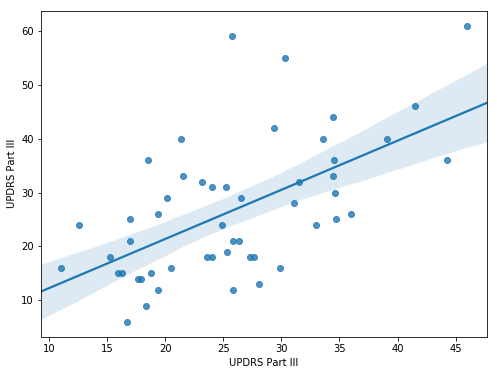

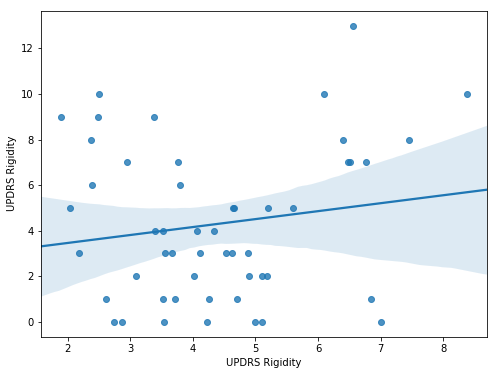

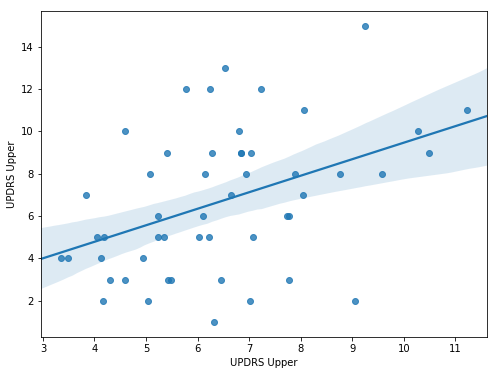

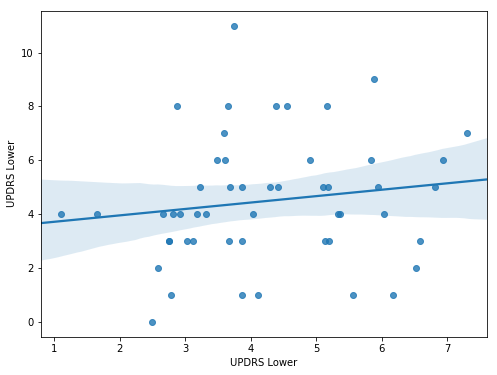

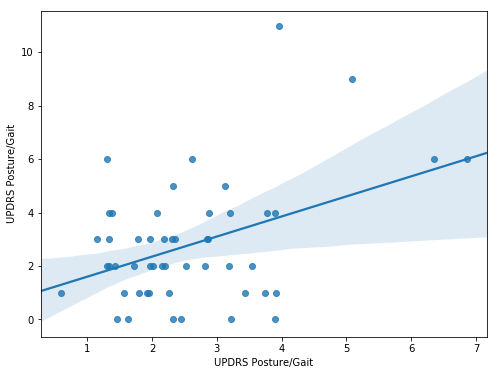

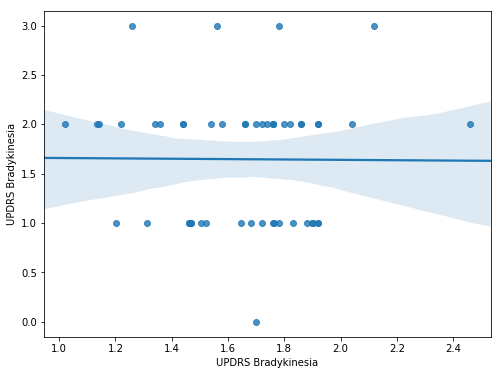

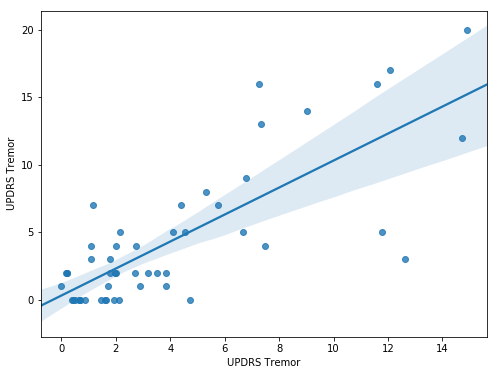

In [380]:
for column in Outcomes.columns:
    S = Outcomes[column].apply(lambda x: (x[0]-x[1])**2).sum()
    M = Outcomes[column].apply(lambda x: x[1]).mean()
    MD = Outcomes[column].apply(lambda x: (x[0]-x[1])).mean()
    SD = Outcomes[column].apply(lambda x: (x[0]-x[1])).std()
    print(column, np.sqrt(S), np.sqrt(S)/M, MD, SD)
    plt.figure(figsize=(8,6))
    sns.regplot(Outcomes[column].apply(lambda x: x[0]),Outcomes[column].apply(lambda x: x[1]))

In [ ]:

sns.regplot(Outcomes[column].apply(lambda x: x[0]),Outcomes[column].apply(lambda x: x[1]))

## Ipsilateral vs. Contralateral Scores

In [7]:
BilatScores = pd.DataFrame()

In [21]:
BilatScores = pd.DataFrame()
for ind in D.index:
    row = D.loc[ind,:]
    side = row.Q03
    try:
        side = side.lower()
        otherside = (set(['left','right'])-set([side]))
        otherside = [x for x in otherside][0]
    except(AttributeError):
        print(row.SubjectCode, row.VisitNm, row.Q03)
        continue
    for task, task_abr in zip(taskList,taskList_Abb):
        newind = len(BilatScores.index)
        RowScores = pd.DataFrame(columns=['ipsi', 'contra'], index=[ind])
        QInd = Questions.zFieldNm==task+' tremor '+side+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
        RowScores['ipsi'] = row[QNum].values[0]
        QInd = Questions.zFieldNm==task+' tremor '+otherside+' upper limb rating'
        QNum = Questions[QInd].zFieldNb
        RowScores['contra'] = row[QNum].values[0]
        
        BilatScores = pd.concat((BilatScores,RowScores))

1005.0 2 Weeks: Time 120 nan
1005.0 1 Month nan
1020.0 2 Weeks: Time 0 nan
1020.0 2 Weeks: Time 30 nan
1020.0 2 Weeks: Time 60 nan
1020.0 2 Weeks: Time 90 nan
1020.0 2 Weeks: Time 120 nan
1020.0 2 Weeks: Time 150 nan
1047.0 1 Month nan
1048.0 2 Weeks: Time 150 nan


In [10]:
BilatScores.corr()

,left,right
left,1.000000,0.342239
right,0.342239,1.000000


In [22]:
BilatScores.corr()

,ipsi,contra
ipsi,1.000000,0.407596
contra,0.407596,1.000000


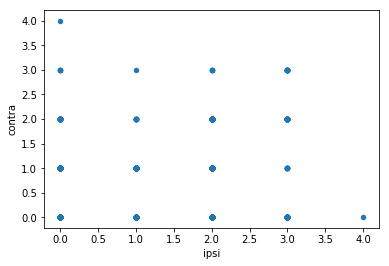

In [25]:
BilatScores.plot(x='ipsi',y='contra',kind = 'scatter')

In [53]:
BilatScoreCounts = pd.DataFrame(columns=[0, 1, 2, 3, 4], index = [0, 1, 2, 3, 4])
for x,y in itertools.product([0,1,2,3,4],[0,1,2,3,4]):
    BilatScoreCounts.loc[x,y] = sum((BilatScores.ipsi==x)&(BilatScores.contra==y))/sum(BilatScores.ipsi==x)

In [54]:
BilatScoreCounts = BilatScoreCounts[BilatScoreCounts.columns].astype(float)

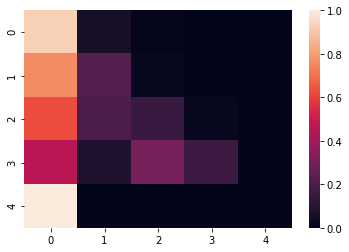

In [55]:
sns.heatmap(BilatScoreCounts)